# FRAUD DETECTION IN CREDIT CARDS

In [1]:
# Cell 1: Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost as xgb

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, average_precision_score


In [2]:
# ==================================
# FRAUD DETECTION IN CREDIT CARDS
# ==================================

# STEP 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from xgboost import XGBClassifier
import pickle


In [3]:
#STEP 2: Load Dataset
# Cell 2 — Load dataset & quick check (run)

import os
df = pd.read_csv(r"C:\Users\janap\Downloads\archive (5)\creditcard.csv")

# Show first 5 rows
df.head()



,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


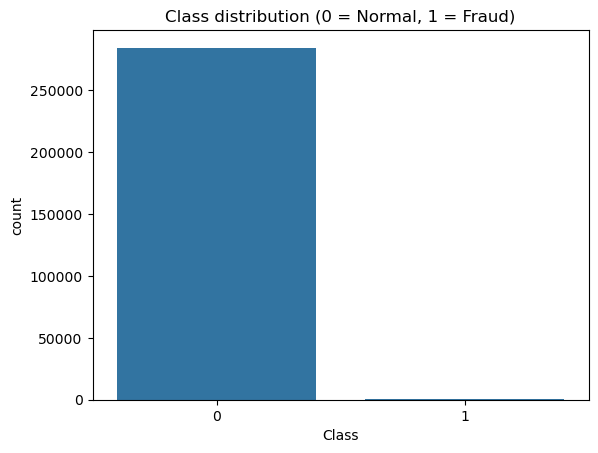

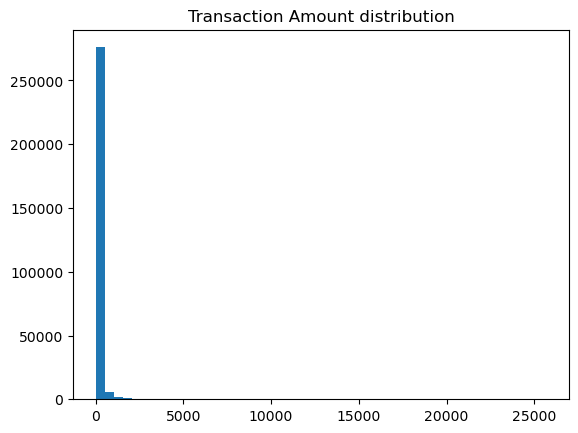

In [4]:
# Cell 3: Quick EDA
sns.countplot(x='Class', data=df)
plt.title("Class distribution (0 = Normal, 1 = Fraud)")
plt.show()

# Amount distribution
plt.hist(df['Amount'], bins=50)
plt.title("Transaction Amount distribution")
plt.show()


In [5]:
# Cell 4: Split and scale
X = df.drop('Class', axis=1)
y = df['Class']

# Stratified split preserves imbalance ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Scale Amount (other columns V1..V28 are already PCA-like)
scaler = StandardScaler()
X_train['Amount'] = scaler.fit_transform(X_train[['Amount']])
X_test['Amount'] = scaler.transform(X_test[['Amount']])

# Save scaler for inference later
joblib.dump(scaler, os.path.join("..", "models", "scaler.pkl"))
print("Scaler saved to models/scaler.pkl")

print("Train class distribution:\n", y_train.value_counts())
print("Test class distribution:\n", y_test.value_counts())


Scaler saved to models/scaler.pkl
Train class distribution:
 Class
0    227451
1       394
Name: count, dtype: int64
Test class distribution:
 Class
0    56864
1       98
Name: count, dtype: int64


In [6]:
# Cell 5: Train a baseline XGBoost
scale_pos_weight = (y_train==0).sum() / (y_train==1).sum()
print("scale_pos_weight:", scale_pos_weight)

model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    # use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    verbosity=1
)

# Use DataFrame (X_train) directly
model.fit(X_train, y_train)


scale_pos_weight: 577.2868020304569


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

Confusion Matrix:
[[56853    11]
 [   16    82]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.84      0.86        98

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.9683850045364235
Average Precision (AP): 0.8787499716229655


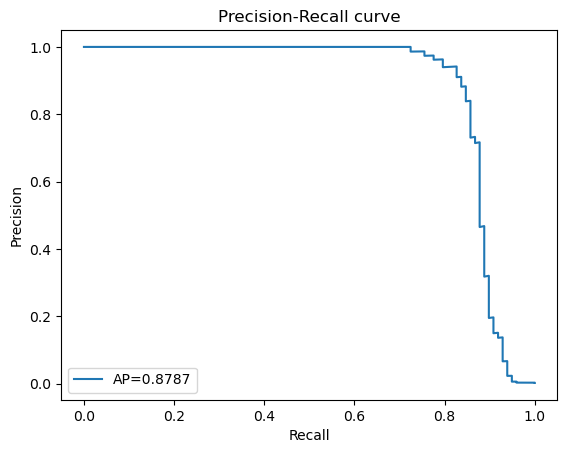

In [7]:
# Cell 6: Evaluate using probabilities
y_proba = model.predict_proba(X_test)[:,1]
y_pred = (y_proba >= 0.5).astype(int)   # default threshold: 0.5

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

# Precision-Recall and Average Precision
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
print("Average Precision (AP):", ap)

# Plot PR curve
plt.plot(recall, precision, label=f"AP={ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")
plt.legend()
plt.show()


In [8]:
# Cell 7: Save model to JSON (recommended)
MODEL_PATH = os.path.join("..", "models", "fraud_model.json")
model.save_model(MODEL_PATH)
print("Model saved to:", MODEL_PATH)


Model saved to: ..\models\fraud_model.json


In [9]:
featfile = os.path.join("..", "models", "feature_columns.txt")
with open(featfile, "w") as f:
    f.write(",".join(X_train.columns.tolist()))
print("Saved feature order to:", featfile)


Saved feature order to: ..\models\feature_columns.txt


In [10]:
# Cell 8: load and test (optional, but good)
loaded = xgb.XGBClassifier()
loaded.load_model(MODEL_PATH)

sample = X_test.iloc[0:3].copy()
sample_proba = loaded.predict_proba(sample)[:,1]
sample_pred = (sample_proba >= 0.5).astype(int)
print("Probs:", sample_proba)
print("Preds:", sample_pred)


Probs: [4.8360080e-06 6.8646068e-06 1.4487485e-05]
Preds: [0 0 0]
